**Class 4: Control problems, model-free Policy Optimization.**

1. [Everything you need to know](#everything)
2. [General view on policy optimization: Generalized Policy Iteration and Actor-Critic architectures](#GPI)
3. [Online problems, the exploration vs. exploitation dilemma](#online)
    1. [SARSA](#sarsa)
    2. [Q-learning](#qlearning)
    3. [Going further with SARSA and Q-learning](#further)
4. [Interactive problems](#interactive)
5. [Offline problems, focussing on the critic alone](#offline)
    1. [Fitted Q-iteration](#fqi)
    2. [Least Squares Policy Iteration](#lspi)

# <a id="everything"></a>Everything you need to know

Everything you should remember after this session.<br>
<br>
<div class="alert alert-success">
<ul>
<li> Generalized Policy Iteration: perform sample-based policy evaluation and policy improvement, directly from samples (not from the model anymore), converge to $Q^*$ and $\pi^*$
<li> Actor-critic architecture: the actor chooses an action based on the current state and the information provided by the critic, while the critic constantly aims at learning relevant things in order to help the actor decide (value functions for example, or an approximate model).
<li>A GLIE actor guarantees that, as $t\rightarrow\infty$, 1) all state-action pairs $(s,a)$ are visited infinitely often for $Q$-updates of the critic and 2) the actor's policy $\pi$ becomes $Q$-greedy.
<li>SARSA. Initialize : in $s$, choose (*actor*) $a$ using $Q$, then repeat:
<ol>
<li> Observe $r$, $s'$
<li> Choose $a'$ (<i>GLIE actor<i>) using $Q$
<li> Temporal difference: $\delta=r+\gamma Q(s',a') - Q(s,a)$
<li> Update $Q$: $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$
<li> $s\leftarrow s'$, $a\leftarrow a'$
</ol>
<li>Q-learning.
<ol>
<li> In $s$, choose $a$ (<i>GLIE actor<i>)
<li> Observe $r$, $s'$
<li> Temporal difference: $\delta=r+\gamma \max_{a'} Q(s',a') - Q(s,a)$
<li> Update $Q$: $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$
<li> $s\leftarrow s'$
</ol>
<li> Fitted Q-iteration (offline learning). For $i=1$ to $N$:
<ol>
<li> For each sample $(s,a,r,s')$, define $(x,y)$ with:<br>
$x = (s,a)$<br>
$y = r + \gamma \max_{a'} Q_{i-1}(s',a')$<br>
Call $\mathcal{T}$ the training set $\left\{(x,y)\right\}$
<li> $Q_i$ = fit_model$(\mathcal{T})$
</ol>
<li> Least Squares Policy Iteration (LSPI) uses the LSTD$Q$ (Least Squares Temporal Differences on $Q$ functions) procedure to approximate the $Q$ function of the current policy, using a set of feature functions $\varphi$, then replaces the current policy with the $Q$-greedy policy and iterates until convergence.
<li> LSTD$Q$ (incremental version):<br>
$\tilde{B} = \frac{1}{\delta}I$ with $\delta$ a small positive value.<br>
$\tilde{b} = 0$<br>
For each $(s,a,r,s') \in \mathcal{D}$:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\tilde{B} \leftarrow \tilde{B} - \frac{B \varphi(s,a) \left( \varphi(s,a) - \gamma\varphi(s',\pi(s')) \right)^T B}{1 + \left( \varphi(s,a) - \gamma\varphi(s',\pi(s')) \right)^T B \varphi(s,a)} $<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\tilde{b} \leftarrow \tilde{b} + \varphi(s,a) r$<br>
return $w_\pi = \tilde{B} b$
</ul>
</div>

Of course, all this seems very obscure right now and the block above will only serve as a reminder when you re-open the notebook later. We will introduce every concept intuitively and progessively.

# <a id="gpi"></a>General view on policy optimization: Generalized Policy Iteration and Actor-Critic architectures

Remember how we went from Policy Iteration (figure below) to Asynchronous Policy Iteration?
<img src="img/policyiteration.png"></img>

Now recall the principle of Asynchronous Policy Iteration. If we consider the two elementary operations:
- Bellman backup on $Q$: $Q(s,a) \leftarrow r(s,a) + \gamma \sum\limits_{s'} p(s'|s,a) Q(s',\pi(s'))$
- Bellman backup on $\pi$: $\pi(s) \leftarrow \arg\max_{a} Q(s,a)$

Then, as long as every state and every action is visited infinitely often for Bellman backups on $Q$ or $\pi$, the sequences of $Q_n$ and $\pi_n$ converge to $Q^*$ and $\pi^*$.

Value Iteration: in each state, one update of $Q$ and one improvement of $\pi$.<br>
Policy Iteration: update $Q$ in all states until convergence, then update $\pi$ in all states.

**Generalized Policy Iteration** is the case where one has two interacting processes: policy evaluation and policy improvement, directly from samples (not from the model anymore). If these processes converge to their respective targets, then Generalized Policy Iteration converges to $Q^*$ and $\pi^*$. Model-free policy evaluation can take many forms: indirect RL, Monte Carlo evaluations, TD methods...

This leads to the definition of the general **actor-critic architectures** (excerpt from **Algorithms for Reinforcement Learning** by C. Szepesvari):

<img src="img/actor-critic.png"  style="width: 500px;"></img>

In such architectures, an *actor* chooses an action based on the current state and the information provided by the *critic*, while the *critic* constantly aims at learning relevant things in order to help the *actor* decide (value functions for example, or an approximate model).

Almost all Reinforcement Learning algorithms fall into an actor-critic architecture. The following sections separate the search for optimal policies / value functions into two distinct contexts:
<ul>
<li> Online interaction. The actor needs to balance exploration of new state-action pairs with the exploitation of those which are already known to be good (in order to guide the agent along reward-providing trajectories and to refine the knowledge of the value function around these trajectories). The critic aims at providing the best evaluation of state-action pairs to the actor. In this context, we derive two algorithms:
<ul>
<li>SARSA, where the critic evaluates the current policy being applied.
<li>Q-learning, where the critic evaluates the optimal policy.<br>
</ul>
In particular, online learning is characterized by the fact that the agent chooses the action to perform, but is constrained by the state dynamics and thus does not choose the states to sample. One can think of this case as the direct interaction with an environment.
<li> Interactive problems. These only differ from the online case by the fact that both sampled states and actions can be controled by the learning process. Think of this case as one where one has a simulator and can choose to reset it to any state before deciding on the action to undertake.
<li> Offline policy search. In this case, there simply is no actor and the problem boils down to designing a critic that provides $Q^*$. For this problem, we explore two generalizations of Value Iteration and Policy Iterations, respectively:
<ul>
<li>Fitted Q-Iteration
<li>Least Squares Policy Iteration
</ul>
</ul>

# <a id="online"></a>Online problems, the exploration vs. exploitation dilemma

In the class on value estimation problems, we introduced temporal differences algorithms such as TD(0), so we have a way to evaluate policies. But now, we are not looking for $V^\pi$ anymore (or $Q^\pi$), but for $Q^*$. Let's recall TD(0) on $Q$ functions. Given a sample $(s,a,r,s')$:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma Q(s',\pi(s')) - Q(s,a) \right)$$
Recall that for this update to converge, we need samples for all state-action pairs $(s,a)$.

Using TD(0) (or a Monte Carlo estimator), we could easily design an approximate policy iteration algorithm that evaluates $\pi$ for a certain time, yielding a value function $Q$, then replaces $\pi$ with the $Q$-greedy policy and starts over. So the key question becomes knowing when to switch from evaluation of $\pi$ to improvement. As we have seen in Generalized Policy Iteration, we can interleave those two processes.

For an agent interacting with a new, unknown environment, let's first learn the $Q$-function of a given policy $\pi$. The key problem is to insure all state-action pairs will be sampled. To do this, we can make an **ergodocity** assumption on our MDP, that is we can suppose that each state is reachable from any other (non-terminal) state with non-zero probability. Therefore, acting randomly insures exploration of all state-action pairs.<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Let's implement that on the policy that always goes right in the FrozenLake environment.
<ul>
<li> We will start by using the class on MDPs to obtain the true value of $Q^\pi$.
<li> We will also reproduce the TD(0) estimation of $V^\pi$ from the class on value estimation.
<li> Then we will use it to initialize $Q$ and implement the TD(0) update that converges to $Q^\pi$.
</ul>
As before, to keep things simple, we set $\alpha=0.001$ and we take $\gamma=0.9$.
</div>

In [1]:
import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

In [2]:
env = gym.make('FrozenLake-v0')
actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}

Qtrue:
 [[0.013 0.013 0.013 0.011]
 [0.007 0.012 0.012 0.016]
 [0.031 0.023 0.027 0.012]
 [0.008 0.008 0.    0.008]
 [0.024 0.02  0.019 0.009]
 [0.    0.    0.    0.   ]
 [0.064 0.056 0.064 0.008]
 [0.    0.    0.    0.   ]
 [0.02  0.059 0.049 0.064]
 [0.105 0.161 0.146 0.071]
 [0.23  0.211 0.186 0.063]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.134 0.257 0.301 0.211]
 [0.313 0.59  0.556 0.479]
 [0.    0.    0.    0.   ]]
number of iterations: 18
Vtrue:
 [0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]


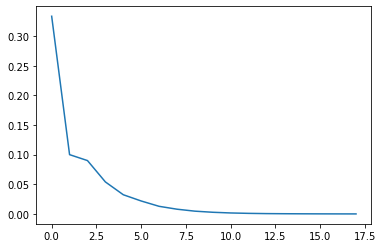

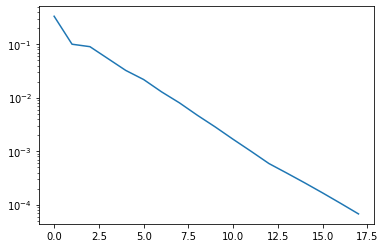

In [3]:
# Policy definition and parameters
pi0 = fl.RIGHT*np.ones((env.observation_space.n),dtype=np.int)
gamma = 0.9
alpha = 0.001

# Model based evaluation
def policy_Qeval_iter(pi, epsilon, max_iter):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for x in range(env.observation_space.n):
            for a in range(env.action_space.n):
                Q2[x][a] = 0
                outcomes = env.unwrapped.P[x][a]
                for o in outcomes:
                    p = o[0]
                    y = o[1]
                    r = o[2]
                    Q2[x][a] += p * (r + gamma*Q1[y][pi[y]])
        residuals[i] = np.max(np.abs(Q2-Q1))
        Q1[:] = Q2
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return Q1, residuals

Qpi0true, residuals = policy_Qeval_iter(pi0,1e-4,10000)
print("Qtrue:\n", Qpi0true)
print("number of iterations:", residuals.size)
plt.plot(residuals)
plt.figure()
plt.semilogy(residuals)

Vpi0true = np.zeros((env.observation_space.n))
for x in range(env.observation_space.n):
    Vpi0true[x] = Qpi0true[x][pi0[x]]
print("Vtrue:\n", Vpi0true)

[0.013 0.011 0.025 0.    0.018 0.    0.061 0.    0.049 0.144 0.183 0.
 0.    0.303 0.566 0.   ]
[0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]


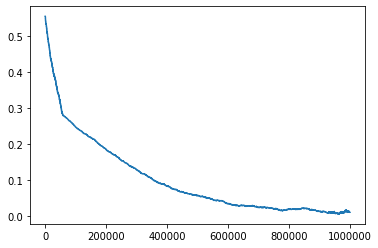

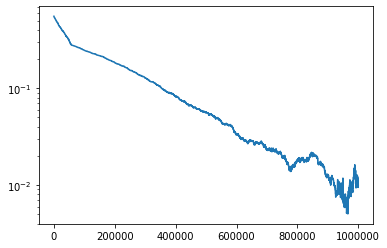

In [4]:
# TD(0) evaluation of Vpi
def TD_Veval(pi, max_steps, V=None, Vtrue=None):
    if(V is None):
        V = np.zeros((env.observation_space.n))
    error = np.zeros((max_steps))
    x = env.reset()
    for t in range(max_steps):
        y,r,d,_ = env.step(pi[x])
        V[x] = V[x] + alpha * (r+gamma*V[y]-V[x])
        if(Vtrue is not None):
            error[t] = np.max(np.abs(V-Vtrue))
        if d==True:
            x = env.reset()
        else:
            x=y
    return V, error

Vpi0, error = TD_Veval(pi0, 1000000, Vtrue=Vpi0true)
print(Vpi0)
print(Vpi0true)
plt.plot(error)
plt.figure()
plt.semilogy(error);

Max error: 0.011110371160418742


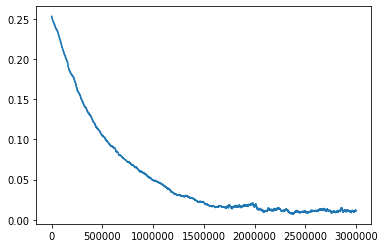

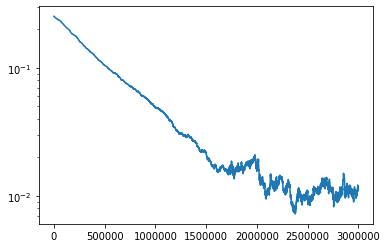

In [5]:
# TD(0) evaluation of Qpi
Qpi0 = np.transpose(np.tile(Vpi0, (4,1)))

def TD_Qeval(pi, max_steps, Q=None, Qtrue=None):
    error = np.zeros((max_steps))
    if (Q is None):
        Q = np.zeros((env.observation_space.n, env.action_space.n))
    x = env.reset()
    for t in range(max_steps):
        a = np.random.randint(4)
        y,r,d,_ = env.step(a)
        Q[x][a] = Q[x][a] + alpha * (r+gamma*Q[y][pi[y]]-Q[x][a])
        if(Qtrue is not None):
            error[t] = np.max(np.abs(Q-Qtrue))
        if d==True:
            x = env.reset()
        else:
            x=y
    return Q, error

Qpi0, error = TD_Qeval(pi0,3000000,Qpi0,Qpi0true)
print("Max error:", np.max(np.abs(Qpi0-Qpi0true)))
plt.plot(error)
plt.figure()
plt.semilogy(error);

So we have a way of evaluating $Q^\pi$. But we're interested in $Q^*$. Let's use the idea of Generalized Policy Iteration and include, inside the TD(0) loop above, the policy improvement phase $\pi(s) \leftarrow \arg\max_a Q(s,a)$. This means that at each time step, instead of evaluating the temporal difference for a fixed policy $\pi$, we evaluate a policy that is $Q$-greedy. According to the convergence property of Generalized Policy Iteration, this should converge to $Q^*$. But then again, the policy applied by our agent remains totally random so it clearly does not converge to $\pi^*$. To solve this issue we introduce the notion of **Greedy in the limit of infinite exploration** (GLIE) actor:<br>
<br>
<div class="alert alert-success"><b>Greedy in the limit of infinite exploration</b> (GLIE) actor:<br>
A GLIE actor guarantees that:<br>
- All state-action pairs $(s,a)$ are visited infinitely often for updates of $Q$, as $t\rightarrow\infty$:
$$\lim_{t\rightarrow\infty} count_t(s,a) = \infty$$
- As $t\rightarrow\infty$ the actor becomes $Q$-greedy, that is:
$$\lim_{t\rightarrow\infty} \pi_t(a|s) = \mathbb{1}\left(a = \arg\max_{\hat{a}} Q(s,\hat{a})\right)$$
</div>

An example of GLIE actor is the so-called $\epsilon$-greedy exploration strategy that uniformly picks a non-greedy action with probability $\epsilon$:
$$\pi_t(a|s) = \left\{\begin{array}{ll}1-\epsilon_t & \textrm{if }a=\arg\max_{\hat{a}} Q(s,\hat{a})\\
\frac{\epsilon_t}{|A|-1} & \textrm{otherwise} \end{array}\right.$$
With a parameter $\epsilon_t>0$ that goes to zero as $t$ tends to $\infty$, one obtains a GLIE actor.

GLIE actors (or policies) enforce the limits of the **exploration vs. exploitation compromise**. As long as actors respect the GLIE properties, actor-critic architectures fall within the convergence properties of Generalized Policy Iteration.

With this last definition, we have all the ingredients to define algorithms that evolve to an optimal behaviour.

<a href="#GLIEremark" data-toggle="collapse"> A remark</a><br>
<div id="GLIEremark" class="collapse">
You might have noticed that the totally random policy we applied in the TD(0) update was a very naive choice. Even if all states are reachable from anywhere in the state space (ergodicity property), they might not all be visited with the same frequency and therefore the convergence to $Q^\pi$ might be delayed because of this uniform exploration strategy.<br>
<br>
The same remark applies to $\epsilon$-greedy exploration strategies that often start with $\epsilon=1$ and let it slowly decrease towards zero. These strategies don't account for the actual *visitation frequencies* of state-action pairs. In some states it might be good to keep a strong exploration probability because they actually have been seldom visited, while in other states, a faster decrease is desirable. This links also to the question of *value propagation* that was underpinned by the asynchronous value iteration remarks in the class on MDPs.<br>
<br>
The point here is to notice that $\epsilon$-greedy is a simple, very naive exploration strategy that fits within the GLIE requirements but that much better exploration policies are possible by taking the current state into account (contextual exploration) or by using the values of the temporal difference (prioritized experience replay) and the $Q$ estimate (Boltzmann policies, $E^3$ or $R_{max}$ strategies) for instance.
</div>

## <a id="sarsa"></a>SARSA

The key idea behind the SARSA algorithm is to build a critic that constantly tries to evaluate the value $Q$ of the actor's policy $\pi$, and an actor that tends to be greedy with respect to this critic. The algorithm is written:

<div class="alert alert-success"><b>SARSA</b><br>
In $s$, choose (*actor*) $a$ using $Q$, then repeat:
<ol>
<li> Observe $r$, $s'$
<li> Choose $a'$ (<i>GLIE actor</i>) using $Q$
<li> Temporal difference: $\delta=r+\gamma Q(s',a') - Q(s,a)$
<li> Update $Q$: $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$
<li> $s\leftarrow s'$, $a\leftarrow a'$
</ol>
SARSA converges if the actor is GLIE and if $\alpha$ respects the Robbins-Monro conditions.
</div>

It is important to note that SARSA is an **on-policy** critic: it constantly evaluates the current $\pi$... that constantly shifts towards $\pi^*$ by being $Q$-greedy.

The name SARSA comes from the usage of an augmented sample $(s,a,r,s',a')$.<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Let's implement an $\epsilon$-greedy SARSA on the FrozenLake problem.<br>
For the decrease of $\epsilon$ we can opt for a division by 2 every million steps.<br>
You can compare with $Q^*$ and $\pi^*$ obtained during the model-based class.
</div>

In [6]:
# Model-based policy optimization and a few utility functions

def value_iteration(V,epsilon,max_iter):
    W = np.copy(V)
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for s in range(env.observation_space.n):
            Q = np.zeros((env.action_space.n))
            for a in range(env.action_space.n):
                outcomes = env.unwrapped.P[s][a]
                for o in outcomes:
                    p  = o[0]
                    s2 = o[1]
                    r  = o[2]
                    Q[a] += p*(r+gamma*V[s2])
            W[s] = np.max(Q)
            #print(W[s])
        residuals[i] = np.max(np.abs(W-V))
        #print("abs", np.abs(W-V))
        np.copyto(V,W)
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return V, residuals

def Q_from_V(V):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[s][a]
            for o in outcomes:
                p  = o[0]
                s2 = o[1]
                r  = o[2]
                Q[s,a] += p*(r+gamma*V[s2])
    return Q

def greedyQpolicy(Q):
    pi = np.zeros((env.observation_space.n),dtype=np.int)
    for s in range(env.observation_space.n):
        pi[s] = np.argmax(Q[s,:])
    return pi

def to_s(row,col):
    return row*env.unwrapped.ncol+col

def to_row_col(s):
    col = s%env.unwrapped.ncol
    row = int((s-col)/env.unwrapped.ncol)
    return row,col

def print_policy(pi):
    for row in range(env.unwrapped.nrow):
        for col in range(env.unwrapped.ncol):
            print(actions[pi[to_s(row,col)]], end='')
        print()
    return

Vinit = np.zeros((env.observation_space.n))
Vstar,residuals = value_iteration(Vinit,1e-4,1000)
Qstar = Q_from_V(Vstar)
print(actions)
print(Vstar)
print(Qstar)
pi_star = greedyQpolicy(Qstar)
print_policy(pi_star)
env.render();

{0: '←', 1: '↓', 2: '→', 3: '↑'}
[0.068 0.061 0.074 0.055 0.091 0.    0.112 0.    0.145 0.247 0.299 0.
 0.    0.38  0.639 0.   ]
[[0.068 0.066 0.066 0.059]
 [0.039 0.043 0.04  0.061]
 [0.074 0.068 0.072 0.057]
 [0.039 0.039 0.033 0.055]
 [0.091 0.071 0.064 0.048]
 [0.    0.    0.    0.   ]
 [0.112 0.09  0.112 0.022]
 [0.    0.    0.    0.   ]
 [0.071 0.118 0.102 0.145]
 [0.157 0.247 0.204 0.133]
 [0.299 0.266 0.225 0.108]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.188 0.306 0.38  0.266]
 [0.395 0.639 0.615 0.537]
 [0.    0.    0.    0.   ]]
←↑←↑
←←←←
↑↓←←
←→↓←
  (Right)
SFFF
FHFH
FFFH
HFFG


In [7]:
# Let's restart from Qpi0
Qsarsa = Qpi0
max_steps = 5000000

def epsilon_greedy(Q, s, epsilon):
    a = np.argmax(Q[s,:])
    if(np.random.rand()<=epsilon): # random action
        aa = np.random.randint(env.action_space.n-1)
        if aa==a:
            a=env.action_space.n-1
        else:
            a=aa
    return a

# SARSA
count = np.zeros((env.observation_space.n,env.action_space.n)) # to track update frequencies
epsilon = 1
x = env.reset()
a = epsilon_greedy(Qsarsa,x,epsilon)
for t in range(max_steps):
    if((t+1)%1000000==0):
        epsilon = epsilon/2
    y,r,d,_ = env.step(a)
    aa = epsilon_greedy(Qsarsa,y,epsilon)
    Qsarsa[x][a] = Qsarsa[x][a] + alpha * (r+gamma*Qsarsa[y][aa]-Qsarsa[x][a])
    count[x][a] += 1
    if d==True:
        x = env.reset()
        a = epsilon_greedy(Qsarsa,x,epsilon)
    else:
        x=y
        a = aa

# SARSA's final value function and policy
print("Max error:", np.max(np.abs(Qsarsa-Qstar)))

Max error: 0.047458691094004024


In [8]:
print("Final epsilon:", epsilon)
pi_sarsa = greedyQpolicy(Qsarsa)
print("Greedy SARSA policy:")
print_policy(pi_sarsa)
print("Difference between pi_sarsa and pi_star (recall that there are several optimal policies):")
print(pi_sarsa-pi_star)
Qpi_sarsa, residuals = policy_Qeval_iter(pi_sarsa,1e-4,10000)
print("Max difference in value between pi_sarsa and pi_star:", np.max(np.abs(Qpi_sarsa-Qstar)))
print("Min difference in value between pi_sarsa and pi_star:", np.min(np.abs(Qpi_sarsa-Qstar)))

Final epsilon: 0.03125
Greedy SARSA policy:
←↑←↑
←←→←
↑↓←←
←→↓←
Difference between pi_sarsa and pi_star (recall that there are several optimal policies):
[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
Max difference in value between pi_sarsa and pi_star: 9.613535775387927e-05
Min difference in value between pi_sarsa and pi_star: 0.0


The same remark as for TD(0) holds: with a better exploration strategy, the convergence to Qstar could be much more efficient. We can see that some states have been visited (and updated) way more often than others. Let's plot the exploration map for each action.

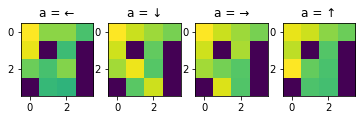

  (Left)
SFFF
FHFH
FFFH
HFFG


In [9]:
count_map = np.zeros((env.unwrapped.nrow, env.unwrapped.ncol, env.action_space.n))
for a in range(env.action_space.n):
    for x in range(env.observation_space.n):
        row,col = to_row_col(x)
        count_map[row, col, a] = count[x,a]

fig, axs = plt.subplots(ncols=4)
for a in range(env.action_space.n):
    name = "a = " + actions[a]
    axs[a].set_title(name)
    axs[a].imshow(np.log(count_map[:,:,a]+1), interpolation='nearest')
    #print("a=", a, ":", sep='')
    #print(count_map[:,:,a])
plt.show()
env.render()

## <a id="qlearning"></a>Q-learning

It is somehow regretable that the convergence of $Q$ to $Q^*$ in SARSA depends on the decrease schedule of $\epsilon$ (because SARSA always tries to evaluate the current policy). One could wish for an algorithm that tries to infer $Q^*$ independently of the actor's policy. In other words, one could wish for an **off-policy** algorithm that converges to $Q^*$. That's Q-learning.

At each time step, Q-learning aims at evaluating what would be the optimal $Q$-function, independently of the policy applied. Thus, its target is $Q^*$ rather than $Q^\pi$. To do this, it simply changes the TD update of SARSA into:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max_{a'} Q(s',a') - Q(s,a)\right]$$

<div class="alert alert-success"><b>Q-learning</b><br>
Repeat:
<ol>
    <li> In $s$, choose $a$ (<i>GLIE actor</i>)
    <li> Observe $r$, $s'$
    <li> Temporal difference: $\delta=r+\gamma \max_{a'} Q(s',a') - Q(s,a)$
    <li> Update $Q$: $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$
    <li> $s\leftarrow s'$
</ol>
Q-learning converges if the actor is GLIE and if $\alpha$ respects the Robbins-Monro conditions.
</div>

The policy applied is not the target of the TD(0) update anymore: we have replaced $Q(s',a')$ by $\max_{a'} Q(s',a')$, so if $Q=Q^*$ we are effectively evaluating an optimal policy. While SARSA was the sample-based implementation of an estimator for the **evaluation equation** (from the MDP class), Q-learning is the implementation of an estimator for the **optimality equation**.

It is important to note that Q-learning is an **off-policy** critic: its target is independent of the policy applied by the actor (but of course the samples $(s,a,r,s')$ depend on the actor).<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Let's implement an $\epsilon$-greedy Q-learning on the FrozenLake problem.<br>
As in the previous exercice, for the decrease of $\epsilon$ we can opt for a division by 2 every million steps.<br>
You can compare with $Q^*$ and $\pi^*$ obtained during the model-based class.
</div>

In [10]:
# Let's restart from Qpi0
Qql = Qpi0
max_steps = 5000000

# Q-learning
count = np.zeros((env.observation_space.n,env.action_space.n)) # to track update frequencies
epsilon = 1
x = env.reset()
for t in range(max_steps):
    if((t+1)%1000000==0):
        epsilon = epsilon/2
    a = epsilon_greedy(Qql,x,epsilon)
    y,r,d,_ = env.step(a)
    Qql[x][a] = Qql[x][a] + alpha * (r+gamma*np.max(Qql[y][:])-Qql[x][a])
    count[x][a] += 1
    if d==True:
        x = env.reset()
    else:
        x=y

# Q-learning's final value function and policy
print("Max error:", np.max(np.abs(Qql-Qstar)))

Max error: 0.012062323695451571


In [11]:
print("Final epsilon:", epsilon)
pi_ql = greedyQpolicy(Qql)
print("Greedy Q-learning policy:")
print_policy(pi_ql)
print("Difference between pi_ql and pi_star (recall that there are several optimal policies):")
print(pi_ql-pi_star)
Qpi_ql, residuals = policy_Qeval_iter(pi_ql,1e-4,10000)
print("Max difference in value between pi_sarsa and pi_star:", np.max(np.abs(Qpi_ql-Qstar)))
print("Min difference in value between pi_sarsa and pi_star:", np.min(np.abs(Qpi_ql-Qstar)))

Final epsilon: 0.03125
Greedy Q-learning policy:
←↑←↑
←←→←
↑↓←←
←→↓←
Difference between pi_ql and pi_star (recall that there are several optimal policies):
[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
Max difference in value between pi_sarsa and pi_star: 9.613535775387927e-05
Min difference in value between pi_sarsa and pi_star: 0.0


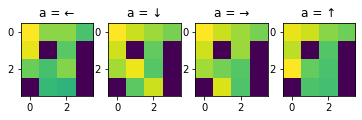

  (Up)
SFFF
FHFH
FFFH
HFFG


In [12]:
count_map = np.zeros((env.unwrapped.nrow, env.unwrapped.ncol, env.action_space.n))
for a in range(env.action_space.n):
    for x in range(env.observation_space.n):
        row,col = to_row_col(x)
        count_map[row, col, a] = count[x,a]

fig, axs = plt.subplots(ncols=4)
for a in range(env.action_space.n):
    name = "a = " + actions[a]
    axs[a].set_title(name)
    axs[a].imshow(np.log(count_map[:,:,a]+1), interpolation='nearest')
    #print("a=", a, ":", sep='')
    #print(count_map[:,:,a])
plt.show()
env.render()

## <a id="further"></a>Going further with SARSA and Q-learning

The exercices below will help you go further with SARSA and Q-learning (you can skip this part if this is the first time you read this notebook). [Link to next part](#offline)
<div class="alert alert-warning"><b>Exercices:</b><br>
<ul>
<li><b>Context-dependent exploration</b><br>
Can you implement an $(s,a)$-dependent $\epsilon$-greedy exploration strategy (by using the `count` table introduced earlier for instance)?
<li><b>Heuristic initialization on $Q$</b><br>
For Q-learning, can you think of an initialization of $Q$ that would be better than plain zeros (for example by exploiting the maximum 1-step reward $r_{max}$)? One that, for instance, would drive the exploration towards unvisited states?
<li><b>Reward shaping</b><br>
Did you notice that falling into a hole brings no penalty? If we introduced a $-1$ reward for falling into a hole, would it change the optimal policy?
<li><b>SARSA($\lambda$)</b><br>
SARSA is an on-policy method and we've seen that so is TD($\lambda$) so it seems rather straightforward to implement a SARSA($\lambda$) algorithm that, hopefully, will have better convergence properties than plain SARSA.
<li><b>$Q(\lambda)$</b><br>
This time it is not as straightfoward to derive a $Q(\lambda)$ algorithm from TD($\lambda$), precisely because TD($\lambda$) evaluates the policy being applied and not another one. Can you imagine a way to still perform $Q(\lambda)$ updates? An answer is found in Watkins's thesis that introduces Q-learning in 1989. For a more recent approach and other references, see Sutton et al, <b>A new Q($\lambda$) with interim forward view and Monte Carlo equivalence</b>, 2014)
<li><b>SARSA and $Q$-learning with linear value function approximation</b><br>
Can you implement an approximate version of SARSA and $Q$-learning with linear Q-function approximation $Q(s,a)=\theta^T\varphi(s,a)$?
</ul>
</div>

<div class="alert alert-danger"><a href="#going" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="going" class="collapse">
TODO
</div>
</div>

# <a id="interactive"></a>Interactive problems

The previous section focused on **online learning**, where the agent could decide, at each step, what action to take (thus making a compromise between exploration and exploitation) but suffered the consequences of this action on the next step with no control over this next states.

However, in many cases, our agent does not interact with the real world but with a simulator, which we can reset to a predefined state. This case, where the agent controls both the state $s$ and the action $a$ in which it queries samples, is called **interactive learning** and online problems are a specific subset of interactive learning problems.

In interactive problems, the exploration vs. exploitation compromise turn to an **active learning** problem. There, the agent should decide to sample more into promising parts or into unexplored parts of $S\times A$.

Currently, this notebook does not cover the case of interactive problems, which will be the focus of the class on Monte Carlo Tree Search. However, the reader is invited to read the excellent discussion in section 4.1 and 4.2 of the **[Algorithms in Reinforcement Learning](https://sites.ualberta.ca/~szepesva/RLBook.html)** book by Csaba Szepesvari (draft freely available online).

# <a id="offline"></a>Offline problems, focussing on the critic alone

If this is the first time you read this notebook, you can skip this part. However, bear in mind that the approaches described below carry many insights as to the construction of efficient critics and, even if they are not as fashionable as Deep Q-learning approaches today, they still represent an important part of the RL literature.

We now turn our attention to offline problems. These are problems where someone provides the agent with a data set $\mathcal{D}=\left\{(s,a,r,s')\right\}$ but allows no interaction with the environment. These are also called *batch learning problems*. The agent is still required to search for an optimal policy.

Obviously, in this setting, there is no *actor* anymore, since there is no interaction with the environment. The question then becomes: can we still learn an optimal policy / value function from this data set?

Obviously, we could try to infer the underlying MDP's transition and reward models from $\mathcal{D}$ and then solve the optimality equation. In the next two sections, we propose two algorithms that respectively approximate Value Iteration and Policy Iteration with the samples from $\mathcal{D}$.

Since there is no exploration in offline RL, it defines a rather specific class of problems for which the curse of dimensionality is less of an issue than in online or interactive RL. Here, the samples set is known from the start and we should make the best possible use of it, with no particular hope that we could get a better coverage of the state-action space. Of course, this translates directly to our ability to generalize well the finite set of samples at our disposal to a value function that covers the full state-action space and therefore, it moves the exploration problem towards a *representation* problem, commonly known in **Supervized Learning** (in particular via the bias-variance tradeoff).

An interesting feature about methods that solve offline RL problems is that they are necessarily off-policy. However, they might still be sensitive to the distribution of samples.

## <a id="fqi"></a>Fitted Q-iteration

Recall the idea of Value Iteration. In every state we performed the Bellman backup:
$$V(s) \leftarrow \max_{a} r(s,a) + \gamma \sum_{s'\in S} p(s'|s,a) V(s')$$
We can write the $Q$-function version of Value Iteration, which we call $Q$-iteration:
$$Q(s,a) \leftarrow r(s,a) + \gamma \sum_{s'\in S} p(s'|s,a) \max_{a'} Q(s',a')$$

The online version of this update leads to the Q-learning algorithm. The offline version will require a function approximator and is called **fitted Q-iteration**.<br>
<br>
<div class="alert alert-success"><b>Fitted Q-iteration</b><br>
Given a regression method "fit_model" and an initial $Q_0=0$.<br>
For $i=1$ to $N$:
<ul>
<li> For each sample $(s,a,r,s')$ in $\mathcal{D}$, define $(x,y)$ with:<br>
$x = (s,a)$<br>
$y = r + \gamma \max_{a'} Q_{i-1}(s',a')$<br>
Call $\mathcal{T}$ the training set $\left\{(x,y)\right\}$
<li> $Q_i$ = fit_model$(\mathcal{T})$
</ul>
</div>

Note that in the tabular case, a straightforward version of fitted Q-iteration boils down to averaging the values of $r + \gamma \max_{a'} Q_{i-1}(s',a')$ for all the $(r,s')$ resulting from the same $(s,a)$.

Of course, the more expressive "fit_model" is, the less error one carries from one iteration to the other. In practice, it is known that fitted Q-iteration might diverge unless some special regressor is used. Kernel smoothing, tree-based methods or neural networks can be good candidates for the implementation of such algorithms. In the cases where fitted Q-iteration converges, it does so to a neighborhood of the optimal $Q^*$.<br>
<br>
A general sufficient condition for the convergence of fitted Q-iteration is to use *averagers*; these are functions that can be decomposed as $Q(s,a)=\sum\limits_{i} \theta_i \varphi_i(s,a)$ with the property that $\forall (s,a), \sum\limits_{i} \varphi_i(s,a) = 1$. Note that *kernel-based methods* are averagers (*tree-based methods* being a specific case of kernel-based methods, with constant 0/1 kernels).<br>
<br>
A good reference on fitted Q-iteration is the article **[Tree based batch mode Reinforcement Learning](http://www.jmlr.org/papers/volume6/ernst05a/ernst05a.pdf)** by Ernst et al. (2004).<br>
An alternative reference, using neural networks instead to tree-based methods is **[Neural Fitted Q-Iteration - first experiences with a data efficient reinforcement learning method](https://pdfs.semanticscholar.org/2820/01869bd502c7917db8b32b75593addfbbc68.pdf)** by Riedmiller (2005).<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Implement a fitted Q-iteration method in the exact tabular case for the FrozenLake problem.<br>
The training data will be collected by performing a uniform random walk.
</div>

In [ ]:
# data generation
N=1000000
XX = np.zeros((N), dtype=np.int)
AA = np.zeros((N), dtype=np.int)
RR = np.zeros((N))
YY = np.zeros((N), dtype=np.int)
count = np.zeros((env.observation_space.n,env.action_space.n)) # to track update frequencies
x = env.reset()
XX[0] = x
for t in range(N):
    a = np.random.randint(4)
    y,r,d,_ = env.step(a)
    XX[t] = x
    AA[t] = a
    RR[t] = r
    YY[t] = y
    count[x,a] += 1
    if d==True:
        x = env.reset()
    else:
        x=y

In [ ]:
count_map = np.zeros((env.unwrapped.nrow, env.unwrapped.ncol, env.action_space.n))
for a in range(env.action_space.n):
    for x in range(env.observation_space.n):
        row,col = to_row_col(x)
        count_map[row, col, a] = count[x,a]

fig, axs = plt.subplots(ncols=4)
for a in range(env.action_space.n):
    name = "a = " + actions[a]
    axs[a].set_title(name)
    axs[a].imshow(np.log(count_map[:,:,a]+1), interpolation='nearest')
    print("a=", a, ":", sep='')
    print(count_map[:,:,a])
plt.show()

In [ ]:
# FQI
FQI_steps=20
Q_fqi = np.zeros((env.observation_space.n, env.action_space.n, FQI_steps))
count = np.zeros((env.observation_space.n, env.action_space.n))
for i in range(XX.shape[0]):
    count[XX[i], AA[i]] +=1

for n in range(1,FQI_steps):
    for i in range(XX.shape[0]):
        Q_fqi[XX[i], AA[i], n] += RR[i] + gamma * np.max(Q_fqi[YY[i], :, n-1])
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            if(count[s,a]!=0):
                Q_fqi[s,a,n] = Q_fqi[s,a,n] / count[s,a]

In [ ]:
pi_fqi = greedyQpolicy(Q_fqi[:,:,FQI_steps-1])
print("Greedy FQI policy:")
print_policy(pi_fqi)
print("Difference between pi_fqi and pi_star (recall that there are several optimal policies):")
print(pi_fqi-pi_star)
Qpi_fqi, residuals = policy_Qeval_iter(pi_fqi,1e-4,10000)
print("Max difference in value between pi_fqi and pi_star:", np.max(np.abs(Qpi_fqi-Qstar)))
print("Min difference in value between pi_fqi and pi_star:", np.min(np.abs(Qpi_fqi-Qstar)))

In [ ]:
delta = np.zeros((FQI_steps))
for n in range(FQI_steps):
    Q, residuals = policy_Qeval_iter(greedyQpolicy(Q_fqi[:,:,n]),1e-4,10000)
    delta[n] = np.max(np.abs(Q-Qstar))

plt.plot(delta)
plt.figure()
plt.semilogy(delta);

In very large state and action spaces, it might be difficult to obtain samples $(s,a)$ covering efficiently the full $S\times A$ space. However, supposing that the approximation method for $Q(s,a)$ is robust to non-uniform $(s,a)$-distributions, one can remark that fitted Q-iteration lends itself quite easily to interleaving the data acquisition phase and the value function improvement. Again, this come with no guarantees concerning convergence but can be an advantage in very large state and action spaces.<br>
<br>
In particular, provided that the database of samples contains enough information about reward providing transitions, it might be interesting to progressively focus the sampling strategy around the last $Q$-greedy policy's state-action distribution. For an example of application of this idea, one can refer to **Clinical data based optimal STI strategies for HIV: a Reinforcement Learning approach** by Ernst et al (2006).<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Implement a modified fitted Q-iteration algorithm that collects new samples at step $n$ by using a $Q_{n-1}$-greedy  $\epsilon$-greedy policy and adds them to the training database.<br>
More precisely, at each enrichment step, add $N$ new samples to the dataset, but only generate $N/10$ of them using $\epsilon = 1 - \frac{i}{9}$ for $i\in [0,9]$.<br>
Start with an initial zero $Q$-function.
</div>
We don't expect to see much of a difference compared to the previous exercice because FrozenLake is just too simple, but we can still do this exercice for practice.

In [ ]:
# incremental FQI
N=100000
XX = np.zeros((0), dtype=np.int)
AA = np.zeros((0), dtype=np.int)
RR = np.zeros((0))
YY = np.zeros((0), dtype=np.int)
FQI_steps=20
Q_fqi = np.zeros((env.observation_space.n, env.action_space.n, FQI_steps))
count = np.zeros((env.observation_space.n,env.action_space.n)) # to track update frequencies
for n in range(1,FQI_steps):
    print("FQI step number", n)
    # data generation
    XXX = np.zeros((N), dtype=np.int)
    AAA = np.zeros((N), dtype=np.int)
    RRR = np.zeros((N))
    YYY = np.zeros((N), dtype=np.int)
    count2 = np.zeros((env.observation_space.n,env.action_space.n))
    epsilon = 1
    Nbatch = np.floor(N/10)
    x = env.reset()
    for i in range(N):
        if (i%Nbatch == 0):
            epsilon -= 1./9.
        a = epsilon_greedy(Q_fqi[:,:,n-1],x,epsilon)
        y,r,d,_ = env.step(a)
        XXX[i] = x
        AAA[i] = a
        RRR[i] = r
        YYY[i] = y
        count2[x,a] += 1
        if d==True:
            x = env.reset()
        else:
            x=y
    XX = np.append(XX,XXX)
    AA = np.append(AA,AAA)
    RR = np.append(RR,RRR)
    YY = np.append(YY,YYY)
    count = count + count2
    print("number of samples in dataset:", XX.shape[0])
    # Value function computation
    for i in range(XX.shape[0]):
        Q_fqi[XX[i], AA[i], n] += RR[i] + gamma * np.max(Q_fqi[YY[i], :, n-1])
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            if(count[s,a]!=0):
                Q_fqi[s,a,n] = Q_fqi[s,a,n] / count[s,a]

In [ ]:
delta = np.zeros((FQI_steps))
for n in range(FQI_steps):
    Q, residuals = policy_Qeval_iter(greedyQpolicy(Q_fqi[:,:,n]),1e-4,10000)
    delta[n] = np.max(np.abs(Q-Qstar))

plt.plot(delta)
plt.figure()
plt.semilogy(delta);

To alleviate the problem of the linearly increasing size of the database in the example above, one could implement, for instance, a uniform random removal over the data set, in order to keep its size bounded. These more advanced tricks and their implications are beyond the scope of this notebook but they give a first flavour of the mini-batches and experience replay tricks that are used in state-of-the-art Deep Reinforcement Learning methods.

FrozenLake is a very simple toy problem with (few) discrete states and actions. So the dataset above covers well the full state-action space. But in the general case, the state-action space might be continuous or just too large to sample extensively. So one has to rely on the generalization properties of a regressor.<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Let's implement a fitted Q-iteration method using Random Forests (or Extremely Randomized Trees) as a regressor over the (row, column, action) feature space.
</div>

In [ ]:
# data generation
N=1000000
XX = np.zeros((N), dtype=np.int)
AA = np.zeros((N), dtype=np.int)
RR = np.zeros((N))
YY = np.zeros((N), dtype=np.int)
x = env.reset()
XX[0] = x
print("data generation")
for t in range(N):
    a = np.random.randint(4)
    y,r,d,_ = env.step(a)
    XX[t] = x
    AA[t] = a
    RR[t] = r
    YY[t] = y
    if d==True:
        x = env.reset()
    else:
        x=y

In [ ]:
#from sklearn.ensemble import RandomForestRegressor as regressor
from sklearn.ensemble import ExtraTreesRegressor as regressor

# Dataset preparation
print("dataset preparation")
nb_samples = XX.shape[0]
Xregr = np.zeros((nb_samples,3))
Yregr = np.zeros((nb_samples))
for i in range(nb_samples):
    row,col = to_row_col(XX[i])
    Xregr[i,0] = row
    Xregr[i,1] = col
    Xregr[i,2] = AA[i]
# X_next_state is a table containing all possible pairs (s',a') ordered as (s0, a0), (s0,a1), (s0,a2), (s1,a0)...
# It will be useful to compute max_a Q(s,a)
X_next_state = np.zeros((env.action_space.n * nb_samples, 3))
index = 0
for i in range(nb_samples):
    row,col = to_row_col(YY[i])
    for a in range(env.action_space.n):
        X_next_state[index,0] = row
        X_next_state[index,1] = col
        X_next_state[index,2] = a
        index = index+1

In [ ]:
# Tree-based FQI (WARNING, the repeated training of the regressor might be very long)

# hack: sink_mask is a vector that is 0 for terminal states and 1 otherwise
# it is used to avoid having non-zero values for max_a Q(s,a), for terminal states s
sinks = {5,7,11,12,15}
sink_mask = np.ones((nb_samples))
for i in range(nb_samples):
    if (YY[i] in sinks):
        sink_mask[i] = 0

# FQI
FQI_steps=20
Qfunctions = []
print("FQI step 0 - training regressor")
Qfunctions.append(regressor(n_estimators=200))
Qfunctions[-1].fit(Xregr,Yregr)
for n in range(1,FQI_steps):
    print("FQI step", n, end=" - ")
    pred_next_state = Qfunctions[-1].predict(X_next_state)
    maxQ2 = np.max((pred_next_state.reshape(nb_samples, env.action_space.n)), axis=1)
    maxQ2 = np.multiply(maxQ2,sink_mask)
    Yregr = RR + gamma * maxQ2
    print("training regressor")
    Qfunctions.append(regressor(n_estimators=200))
    Qfunctions[-1].fit(Xregr,Yregr)

In [ ]:
# Build greedy policy
pi_fqi = np.zeros((env.observation_space.n),dtype=np.int)
for s in range(env.observation_space.n):
    Q = np.zeros((env.action_space.n))
    row,col = to_row_col(s)
    for a in range(env.action_space.n):
        xinput = np.array([row,col,a]).reshape((1,3))
        Q[a] = Qfunctions[-1].predict(xinput)
    pi_fqi[s] = np.argmax(Q)

In [ ]:
print("Greedy FQI policy:")
print_policy(pi_fqi)
print("Difference between pi_fqi and pi_star (recall that there are several optimal policies):")
print(pi_fqi-pi_star)
Qpi_fqi, residuals = policy_Qeval_iter(pi_fqi,1e-4,10000)
print("Max difference in value between pi_fqi and pi_star:", np.max(np.abs(Qpi_fqi-Qstar)))
print("Min difference in value between pi_fqi and pi_star:", np.min(np.abs(Qpi_fqi-Qstar)))

<a href="#sinkmask" data-toggle="collapse">Important remark</a><br>
<div id="sinkmask" class="collapse">
Did you notice the `sink_mask` hack in the code above and its importance?<br>
<br>
When dealing with environments that have terminal states (such as the holes and the frisbee location here), no transitions will ever be sampled from those states. So a regression method (such as Random Forests) will never see samples starting from $(s,a)$ for a terminal $s$ and therefore will never be informed that it should return zero for any transition starting from $s$. Instead, it will return whatever value it can infer from all the other collected data. But the FQI procedure just ignores that fact: when computing $r+\gamma \max_{a'} Q(s',a')$ for terminal $s'$, it will request a scalar value from the regressor that was never informed that it should return value zero. Often, this will result in giving a non-zero value to transitions starting from terminal states and this will bias the resulting value functions and policies. To avoid this phenomenon, we introduced that `sink_mask` vector that zeroes down the $\max_{a'} Q(s',a')$ term for any terminal $s'$. The regressor is still not informed that transitions from $s'$ are worth zero but at least we don't propagate this error through the iterations.
</div>

## <a id="lspi"></a>Least Squares Policy Iteration

Least Squares Policy Iteration (LSPI) answers the question: can we implement a Policy Iteration method based only on samples and given a linear model for the $Q$-function?

Since we are talking about Policy Iteration, the critical step is the evaluation of a given policy.

Suppose $Q^\pi(s,a) = w^T \varphi(s,a)$. We write $\Phi$ the matrix of feature evaluations for all pairs $(s,a)$, that is:
$$\Phi = \left[\begin{array}{ccc}\varphi_0(s_0,a_0) & \cdots & \varphi_0(s_{|S|},a_{|A|}) \\
\vdots & \ddots & \vdots \\
\varphi_K(s_0,a_0) & \cdots & \varphi_K(s_{|S|},a_{|A|}) \end{array} \right]$$

Then, $Q^\pi = r^\pi + \gamma P^\pi Q^\pi$ becomes:
$$\Phi w_\pi = r^\pi + \gamma P^\pi \Phi w_\pi$$

But $r^\pi + \gamma P^\pi \Phi w_\pi$ has no reason to lie within $span(\varphi)$. So we should consider its projection on $span(\varphi)$ as illustrated by the figure below.

<img src="img/projection.png" style="width: 600px;"></img>

The projection operator on $span(\varphi)$ is $\Phi\left(\Phi^T \Phi\right)^{-1} \Phi^T$. And thus $w_\pi$ is a solution to:
$$\Phi w_\pi = \Phi\left(\Phi^T \Phi\right)^{-1} \Phi^T \left( r^\pi + \gamma P^\pi \Phi w_\pi \right)$$

And this system can be solved as (for a proof, see the seminal paper **[Least Squares Policy Iteration](http://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf)** by Lagoudakis and Parr in 2003):
$$w_\pi  = \left[\Phi^T\left(\Phi - \gamma P^\pi \Phi\right)\right]^{-1}\Phi^T r^\pi$$

Let $A = \Phi^T\left(\Phi - \gamma P^\pi \Phi\right)$ and $b=\Phi^T  r^\pi$. We have $w_\pi = A^{-1}b$ so the question becomes: can we compute $A$ and $b$ from samples?

Taking a closer look at $A$ and $b$, we have:
$$A = \sum\limits_{s\in S} \sum\limits_{a\in A} \sum\limits_{s'\in S} p(s'|s,a) \left[ \varphi(s,a) \left( \varphi(s,a) - \gamma\varphi(s',\pi(s')) \right)^T \right]$$
$$b= \sum\limits_{s\in S} \sum\limits_{a\in A} \sum\limits_{s'\in S} p(s'|s,a) \left[ \varphi(s,a) r(s,a,s')\right]$$

And thus $A$ is the sum of many matrices of the form $\varphi(s,a) \left( \varphi(s,a) - \gamma\varphi(s',\varphi(s')) \right)^T$ and $b$ is the sum of many vectors of the form $\varphi(s,a) r(s,a,s')$.

And so, finally, with $\mathcal{D}=\left\{(s_i,a_i,r_i,s'_i)\right\}_{i=1..N}$, $A$ and $b$ can be approximated by:
$$A \approx \frac{1}{N} \sum\limits_{i=1}^N\left[\varphi(s_i, a_i)\left(\varphi(s_i, a_i) - \gamma \varphi(s'_i, \pi(s'_i))\right)^T\right]$$
$$b \approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \varphi(s_i,a_i)r_i \right]$$

From these expressions one gets the LSTD$Q$ (Least Squares Temporal Differences on $Q$ functions) algorithm that evaluates policy $\pi$ given a function basis $\varphi$:
<div class="alert alert-success"><b>LSTD$Q(\pi,\varphi)$</b>:<br>
$K=\dim(Im(\varphi))$<br>
$\tilde{A} = 0_{K\times K}$<br>
$\tilde{b} = 0_K$<br>
For each $(s,a,r,s') \in \mathcal{D}$:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\tilde{A} \leftarrow \tilde{A} + \varphi(s,a) \left( \varphi(s,a) - \gamma\varphi(s',\pi(s')) \right)^T$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\tilde{b} \leftarrow \tilde{b} + \varphi(s,a) r$<br>
return $w_\pi = \tilde{A}^{-1} b$
</div>

LSTD$Q$ requires the inversion of $\tilde{A}$, which my not be full rank until a sufficient number of samples have been processed. One way to avoid  such singularities is to initialize $\tilde{A}$ to a multiple of the identity matrix $\delta I_K$ for some small positive $\delta$, instead of $0_{K\times K}$.

This definition of LSTD$Q$ can be improved by using the Sherman-Morrison formula (incremental computation of the inverse $\tilde{B}$ of $\tilde{A}$) and the algorithm becomes:
<div class="alert alert-success"><b>LSTD$Q(\pi,\varphi)$ with incremental inverse computation</b>:<br>
$\tilde{B} = \frac{1}{\delta}I$ with $\delta$ a small positive value.<br>
$\tilde{b} = 0$<br>
For each $(s,a,r,s') \in \mathcal{D}$:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\tilde{B} \leftarrow \tilde{B} - \frac{B \varphi(s,a) \left( \varphi(s,a) - \gamma\varphi(s',\pi(s')) \right)^T B}{1 + \left( \varphi(s,a) - \gamma\varphi(s',\pi(s')) \right)^T B \varphi(s,a)} $<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\tilde{b} \leftarrow \tilde{b} + \varphi(s,a) r$<br>
return $w_\pi = \tilde{B} b$
</div>

The time complexity of the algorithm above is far lesser ($O(K^2)$) than the one involving the inversion of $\tilde{A}$ ($O(K^3)$).

LSTD$Q$ as defined above computes the weights of any policy $\pi$. We will note this operation: $w \leftarrow$ LSTD$Q$($\pi,\varphi$). But we also remark that given a weights vector $w$, computing the weights for the value of the $w^T \varphi$ -greedy policy requires building $\tilde{B}$ and $\tilde{b}$. This computation requires finding the $\arg\max_{a'\in A} w^T\varphi(s',a')$ in all $s'$ concerned by the updates of $\tilde{B}$, which can be done on the fly, sample after sample, without explicitly storing the greedy policy. Thus we can define the operation $w' \leftarrow$ LSTD$Q$($w, \varphi$) that directly computes the weights $w$ of the policy that is greedy with respect to $w^T\varphi$.

This way, we can evaluate any policy $\pi$ or any $w^T \varphi$-greedy policy given the dataset $\mathcal{D}$. The LSPI algorithm is then simply, given an initial $\pi_0$:<br>
$w' \leftarrow $ LSTD$Q$($\pi_0,\varphi$)<br>
Repeat:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow w'$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w' \leftarrow$ LSTD$Q$($w,\varphi$)<br>
until $\|w-w'\| \leq \epsilon$<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Implement LSTQ$Q$ and LSPI as functions of an initial policy $\pi$.<br>
Since we can (because FrozenLake is very simple), let's use the state-action indicator functions as features.
</div>

In [ ]:
# features
nb_features = env.observation_space.n * env.action_space.n

def phi(s,a):
    val = np.zeros((env.observation_space.n*env.action_space.n))
    index = a*env.observation_space.n + s
    val[index] = 1.
    return val

In [ ]:
# LSTDQ
def LSTDQ_w(w, XX, AA, RR, YY, gamma, phi):
    nb_samples = XX.shape[0]
    delta = 1e-5
    B = (1/delta)*np.eye(nb_features)
    b = np.zeros((nb_features,1))
    for i in range(nb_samples):
        phi1 = phi(XX[i],AA[i]).reshape((nb_features,1))
        Q2 = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            phi2 = phi(YY[i],a)
            Q2[a] = np.dot(w,phi2)
        a2 = np.argmax(Q2)
        phi2 = phi(YY[i],a2).reshape((nb_features,1))
        # update B
        B = B - ( B @ (phi1 @ (phi1-gamma*phi2).T) @ B ) / (1. + (phi1-gamma*phi2).T @ B @ phi1 )
        # update b
        b = b + phi1 * RR[i]
    return (B @ b).ravel()

def LSTDQ_pi(pi, XX, AA, RR, YY, gamma, phi):
    nb_samples = XX.shape[0]
    delta = 1e-5
    B = (1/delta)*np.eye(nb_features)
    b = np.zeros((nb_features,1))
    for i in range(nb_samples):
        phi1 = phi(XX[i],AA[i]).reshape((nb_features,1))
        phi2 = phi(YY[i],pi[YY[i]]).reshape((nb_features,1))
        # update B
        B = B - ( B @ (phi1 @ (phi1-gamma*phi2).T) @ B ) / (1. + (phi1-gamma*phi2).T @ B @ phi1 )
        # update b
        b = b + phi1 * RR[i]
    return (B @ b).ravel()

In [ ]:
# data generation
N=1000000
XX = np.zeros((N), dtype=np.int)
AA = np.zeros((N), dtype=np.int)
RR = np.zeros((N))
YY = np.zeros((N), dtype=np.int)
x = env.reset()
XX[0] = x
print("data generation", end=" - ")
for t in range(N):
    a = np.random.randint(4)
    y,r,d,_ = env.step(a)
    XX[t] = x
    AA[t] = a
    RR[t] = r
    YY[t] = y
    if d==True:
        x = env.reset()
    else:
        x=y
print(N, "data points generated.")

In [ ]:
# LSPI
pi0 = fl.RIGHT*np.ones((env.observation_space.n), dtype=np.int)
max_iterations = 5 # maximum number of iterations for Policy Iteration
epsilon = 1e-4
w = np.zeros((max_iterations, nb_features))
residual = np.zeros((max_iterations))
print("LSPI iteration number 0 (evaluate first policy)")
w[0,:] = LSTDQ_pi(pi0, XX, AA, RR, YY, gamma, phi)
for i in range(1,max_iterations):
    print("LSPI iteration number,", i, "(evaluate greedy policy wrt w)")
    w[i,:] = LSTDQ_w(w[i-1,:], XX, AA, RR, YY, gamma, phi)
    residual[i-1] = np.max(np.abs(w[i,:]-w[i-1,:]))
    print("Residual ||w'-w|| =", residual[i-1])
    if (residual[i-1] < epsilon):
        w = w[:i+1,:]
        residual = residual[:i]
        break

In [ ]:
# Displaying final results
nb_iterations = w.shape[0]

def policy_from_w(w, phi):
    pi = np.zeros((env.observation_space.n),np.int)
    for s in range(env.observation_space.n):
        Q = np.zeros((env.action_space.n))
        for a in range(env.action_space.n):
            Q[a] = np.dot(w,phi(s,a))
        pi[s] = np.argmax(Q)
    return pi

pi_lspi = policy_from_w(w[-1,:],phi)

print("Finished in", nb_iterations, "iterations.")
print("Final LSPI policy:")
print_policy(pi_lspi)
print("Evolution of ||w' - w||:")
val = np.zeros((nb_iterations-1))
for i in range(nb_iterations-1):
    val[i] = np.max(np.abs(w[i+1,:]-w[i,:]))
plt.plot(residual)
plt.show()
print("Difference between pi_lspi and pi_star (recall that there are several optimal policies):")
print(pi_lspi-pi_star)
Qpi_lspi, residuals = policy_Qeval_iter(pi_lspi,1e-4,10000)
print("Max difference in value between pi_lspi and pi_star:", np.max(np.abs(Qpi_lspi-Qstar)))
print("Min difference in value between pi_lspi and pi_star:", np.min(np.abs(Qpi_lspi-Qstar)))

In [ ]:
print("Convergence to pi_star:")
delta = np.zeros((nb_iterations))
for n in range(nb_iterations):
    Q, residuals = policy_Qeval_iter(policy_from_w(w[n,:],phi),1e-4,10000)
    delta[n] = np.max(np.abs(Q-Qstar))

plt.plot(delta)
plt.figure()
plt.semilogy(delta);

As we already knew from the model-based class, Policy Iteration converges in a single iteration for this initial policy. Of course, in more complex domains (continuous, large number of states/actions), more refined feature functions will be required. As an exercice, you can try implementing LSPI on the inverted-pendulum domain from OpenAI Gym.